<a href="https://colab.research.google.com/github/Swapnil5101/MNIST-classification-using-CNN-from-scratch/blob/main/M23MAC009.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Assignment 1
Implementing a Convolutional Neural Network from scratch using PyTorch framework

## Experiment 1

### Import required libraries/modules

In [ ]:
import torch
from torch import nn
import torch.optim as optim
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import struct
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
# Setup the device to run the training data on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

device(type='cpu')

In [ ]:
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

### Load the dataset in suitable format

In [ ]:
# Load training data
with open('/content/drive/MyDrive/DL Assignment1/train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    X_train = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    X_train = X_train.reshape((size, nrows, ncols))

In [ ]:
X_train.shape

(60000, 28, 28)

In [ ]:
X_train.dtype, type(X_train)

(dtype('uint8'), numpy.ndarray)

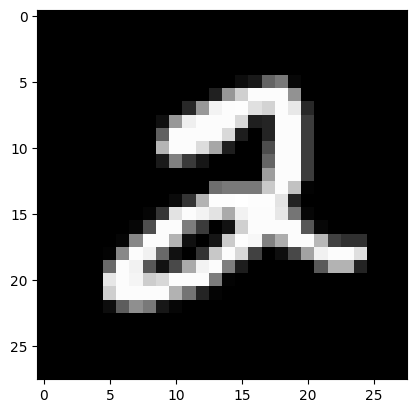

In [ ]:
plt.imshow(X_train[5,:,:], cmap='gray')
plt.show()

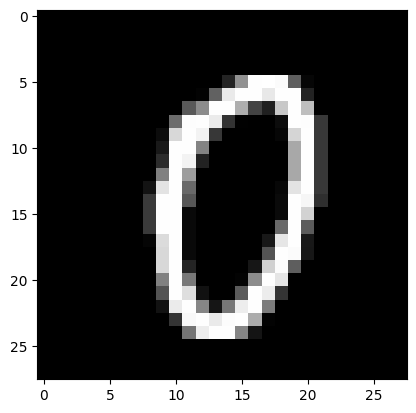

In [ ]:
plt.imshow(X_train[1000,:,:], cmap='gray')
plt.show()

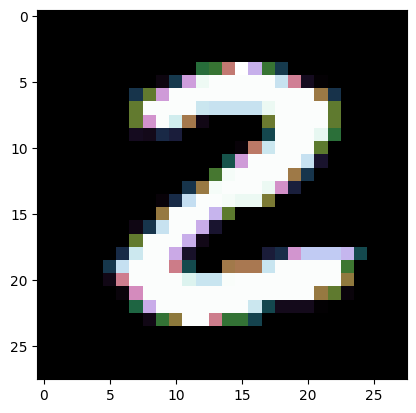

In [ ]:
plt.imshow(X_train[25,:,:], cmap='cubehelix')
plt.show()

In [ ]:
# Load training data labels
with open('/content/drive/MyDrive/DL Assignment1/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_train = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    y_train = y_train.reshape((size, ))    # (size, ) or (1, size)

print(y_train)

[5 0 4 ... 5 6 8]


In [ ]:
y_train.shape

(60000,)

In [ ]:
# Load test data
with open('/content/drive/MyDrive/DL Assignment1/t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    X_test = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    X_test = X_test.reshape((size, nrows, ncols))

In [ ]:
X_test.shape

(10000, 28, 28)

In [ ]:
# Load test data labels
with open('/content/drive/MyDrive/DL Assignment1/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    y_test = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    y_test = y_test.reshape((size, ))    # (size, ) or (1, size)

print(y_test)

[7 2 1 ... 4 5 6]


In [ ]:
y_test.shape

(10000,)

### Check for missing (NaN) values

In [ ]:
np.isnan(np.sum(X_train))

False

In [ ]:
np.isnan(np.sum(y_train))

False

In [ ]:
np.isnan(np.sum(X_test))

False

In [ ]:
np.isnan(np.sum(y_test))

False

The above four results show that there are **no missing (NaN) values** in the whole training and test datasets.

---



### Some Hyperparameters
We shall use the following hyperparameters for training (and for other purposes, wherever needed)

In [ ]:
# Assignment Network architecture's point 4.b applies in my case
batch_size = 16      # 009 % 3 = 0

# learning rate and number of epochs
lr = 0.001
epochs = 10

### Convert numpy arrays into tensors
PyTorch works with tensors

In [ ]:
X_train = torch.from_numpy(X_train).type(torch.float)
y_train = torch.from_numpy(y_train).type(torch.float)

X_test = torch.from_numpy(X_test).type(torch.float)
y_test = torch.from_numpy(y_test).type(torch.float)

In [ ]:
X_train[2,:10,:]

tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.],
        [  0.,   0.,

In [ ]:
X_train.dtype, type(X_train)

(torch.float32, torch.Tensor)

Shapes of different tensors:

In [ ]:
print(f"Shape of X_train = {X_train.shape}, y_train = {y_train.shape}, X_test = {X_test.shape}, y_test = {y_test.shape}")

Shape of X_train = torch.Size([60000, 28, 28]), y_train = torch.Size([60000]), X_test = torch.Size([10000, 28, 28]), y_test = torch.Size([10000])


### Tranforming data and creating loader objects


In [ ]:
# Normalize the train and test data to scale between [0, 1]
X_train = X_train/255
X_test = X_test/255

In [ ]:
X_train[2,:10,:]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

Below is the custom implementation for transforming datasets and then creating their dataloaders.

In [ ]:
from torch.utils.data import Dataset
from torchvision.datasets import utils
import gzip

class CustomDataset(Dataset):
    def __init__(self, images_file, labels_file, transform=None):
        with gzip.open(images_file, 'rb') as f:
            f.read(16)
            buffer = f.read()
            self.images = np.frombuffer(buffer, dtype=np.uint8).reshape(-1, 28, 28)

        with gzip.open(labels_file, 'rb') as f:
            f.read(8)
            buffer = f.read()
            self.labels = np.frombuffer(buffer, dtype=np.uint8)

        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image, label = self.images[idx], int(self.labels[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformation to apply on images
transform = transforms.Compose([transforms.ToTensor()])

# File paths (from google drive)
X_train_file = '/content/drive/MyDrive/DL Assignment1/train-images-idx3-ubyte.gz'
y_train_file = '/content/drive/MyDrive/DL Assignment1/train-labels-idx1-ubyte.gz'
X_test_file = '/content/drive/MyDrive/DL Assignment1/t10k-images-idx3-ubyte.gz'
y_test_file = '/content/drive/MyDrive/DL Assignment1/t10k-labels-idx1-ubyte.gz'

train_dataset = CustomDataset(X_train_file, y_train_file, transform=transform)
test_dataset = CustomDataset(X_test_file, y_test_file, transform=transform)

#### Validation Set

In [ ]:
from  torch.utils.data import random_split

In [ ]:
train_size = int(0.8*len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])
train_labels = [label for _, label in train_dataset]     #<-----
val_labels = [label for _, label in val_dataset]         #<----

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [ ]:
type(train_dataset)

torch.utils.data.dataset.Subset

In [ ]:
len(val_dataset), len(val_labels)

(12000, 12000)

#### DataLoader objects
Train and Test loader objects for Experiment 1

In [ ]:
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

train_loader1 = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_loader1 = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

test_loader1 = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# Length of the dataloaders
print("Length of train_loader1: {}, in batches of {}".format(len(train_loader1), batch_size))
print("Length of val_loader1: {}, in batches of {}".format(len(val_loader1), batch_size))
print("Length of test_loader1: {}, in batches of {}".format(len(test_loader1), batch_size))

Length of train_loader1: 3000, in batches of 16
Length of val_loader1: 750, in batches of 16
Length of test_loader1: 625, in batches of 16


In [ ]:
train_loader1

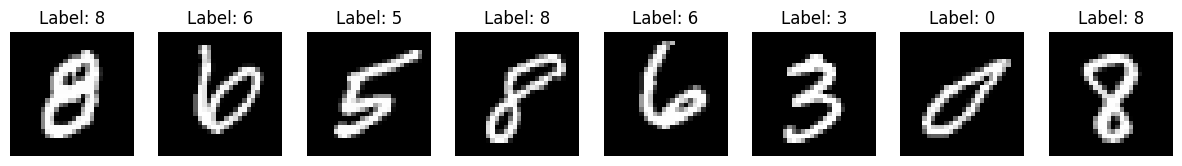

In [ ]:
def display(images, labels, ncols=8):
    nrows = np.ceil(len(images) / ncols)
    fig, axes = plt.subplots(int(nrows), ncols, figsize=(15, 2 * nrows))

    for i, (image, label) in enumerate(zip(images, labels)):
        ax = axes[i // ncols, i % ncols] if nrows > 1 else axes[i % ncols]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.show()

torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

for batch in train_loader1:
    batch_images, batch_labels = batch
    display(batch_images[:8], batch_labels[:8])
    break  #show one batch



### Building the network and a model
**Network Architecture:**
1. The network contains **3 fully convolutional layers, excluding fully connected output
layer.** The network architecture is as following:

  a. ***Convolution layer1***: kernel size = 7x7; Maxpool (2x2);Stride=1;
output channels=16

  b. ***Convolution layer2***: kernel size=5x5; Maxpool (2x2); Stride=1; output channels=8

  c. ***Convolution layer3***: kernel size=3x3; Average pooling (2x2); Stride=2; output
channels=4

  d. ***Output layer***: set to the size of the #classes

  **Assumption:** Filter size = 3x3 is taken for both Maxpool and Average pooling in Experiment 1 and 2x2 in Experiment 2

2. Use ***zero padding*** to preserve the input image dimension.

3. Use standard train-test splits.
4. Set `ReLU` as the activation function for convolution layers and `softmax` for the output
layer.
5. Use `Adam optimizer`; loss function as `cross-entropy`.
6. Train for 10 epochs. Plot accuracy and loss per epoch.
7. Prepare a `Confusion matrix` for the test set for all the combinations of the network.

#### Build the network

In [ ]:
# Creating a CNN class
class ConvNet(nn.Module):
    def __init__(self, num_classes, k, in_fc):
        super(ConvNet, self).__init__()
        # Conv Layer1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=7, stride=1, padding=3)  # Pad to preserve input size
        self.relu1 = nn.ReLU()

        # MaxPool1
        self.maxpool1 = nn.MaxPool2d(kernel_size = k, stride = 1)

        # Conv Layer2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=8, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()

        # MaxPool2
        self.maxpool2 = nn.MaxPool2d(kernel_size = k, stride = 1)

        # Conv Layer3
        self.cnn3 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=1)
        self.relu3 = nn.ReLU()

        # Average Pool3
        self.avgpool3 = nn.AvgPool2d(kernel_size=k, stride=1)

        # Fully Connected output layer
        self.fc1 = nn.Linear(in_features=in_fc, out_features=num_classes)       # <--------- in_features subject to changes

    def forward(self, out: torch.Tensor):
        # Convolution 1
        out = self.cnn1(out)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max pool 2
        out = self.maxpool2(out)

        # Convolution 3
        out = self.cnn3(out)
        out = self.relu3(out)

        # Average pool 3
        out = self.avgpool3(out)

        # Resize
        out = out.view(out.size(0), -1)  # Similar to flattening

        # Linear function
        out = self.fc1(out)

        return out

#### Create a model for the network
'model1' in which all pooling layers have filter size = 3x3 and final size is 4x10x10 (when flattened before output layer)

In [ ]:
# Create the model
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

model1 = ConvNet(10, 3, 4*10*10).to(device)
model1

ConvNet(
  (cnn1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (avgpool3): AvgPool2d(kernel_size=3, stride=1, padding=0)
  (fc1): Linear(in_features=400, out_features=10, bias=True)
)

In [ ]:
# model1 parameters
model1.parameters()

<generator object Module.parameters at 0x7b23ecd736f0>

In [ ]:
# 2nd model
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

model2 = ConvNet(10, 2, 4*12*12).to(device)
model2

ConvNet(
  (cnn1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (avgpool3): AvgPool2d(kernel_size=2, stride=1, padding=0)
  (fc1): Linear(in_features=576, out_features=10, bias=True)
)

In [ ]:
# model2 parameters
model2.parameters()

<generator object Module.parameters at 0x7b23ecd73b50>

### Training the model (Loss and Accuracy)

#### Loss function

In [ ]:
# For multi-class classification, we take cross entropy loss
loss_fn = nn.CrossEntropyLoss()

#### Optimizer

In [ ]:
optimizer1 = torch.optim.Adam(params=model1.parameters(), lr=lr)
optimizer2 = torch.optim.Adam(params=model2.parameters(), lr=lr)

#### Training loop, calculating loss, validation and test accuracy

In [ ]:
def train_validate_model(model, optimizer, train_loader, val_loader):
    train_losses, val_losses, val_accuracies = [], [], []

    # Set seed
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    for epoch in range(epochs):
        model.train()
        current_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, y)
            loss.backward()
            optimizer.step()
            current_loss += loss.item()

        train_losses.append(current_loss / len(train_loader))

        # Evaluate on the validation set
        model.eval()
        val_loss = 0.0
        val_correct, val_total = 0, 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = loss_fn(pred, y)
                val_loss += loss.item() * len(y)
                _, predicted = torch.max(pred.data, 1)
                val_total += y.size(0)
                val_correct += torch.sum(predicted == y).item()   # to convert from torch scalar into normal scalar value

        # Validation loss and accuracy
        val_loss /= len(val_dataset)
        val_losses.append(val_loss / len(val_loader))
        val_acc = val_correct*100 / val_total
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch + 1}/{epochs}], "
              f"Train Loss: {train_losses[-1]:.4f}, "
              f"Validation Loss: {val_losses[-1]:.4f}, "
              f"Validation Accuracy: {val_acc:.4f} ")

    return train_losses, val_losses, val_accuracies

In [ ]:
def test_accuracy(model, test_loader):
    torch.manual_seed(42)
    if torch.cuda.is_available():
       torch.cuda.manual_seed(42)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            _, predicted = torch.max(pred.data, 1)
            total += y.size(0)
            correct += torch.sum(predicted == y).item()   # to convert from torch scalar into normal scalar value

    # Test accuracy
    test_acc = correct*100 / total

    return test_acc

###### Model1 training, validation and testing

In [ ]:
# Train and validate
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

train_losses1, val_losses1, val_accuracies1 = train_validate_model(model1, optimizer1, train_loader1, test_loader1)

Epoch [1/10], Train Loss: 1.7342, Validation Loss: 0.0022, Validation Accuracy: 78.4700 
Epoch [2/10], Train Loss: 1.5257, Validation Loss: 0.0020, Validation Accuracy: 96.5700 
Epoch [3/10], Train Loss: 1.4947, Validation Loss: 0.0020, Validation Accuracy: 96.9000 
Epoch [4/10], Train Loss: 1.4935, Validation Loss: 0.0020, Validation Accuracy: 97.3500 
Epoch [5/10], Train Loss: 1.4913, Validation Loss: 0.0020, Validation Accuracy: 96.2800 
Epoch [6/10], Train Loss: 1.4907, Validation Loss: 0.0020, Validation Accuracy: 96.0700 
Epoch [7/10], Train Loss: 1.4912, Validation Loss: 0.0020, Validation Accuracy: 97.0800 
Epoch [8/10], Train Loss: 1.4895, Validation Loss: 0.0020, Validation Accuracy: 97.2000 
Epoch [9/10], Train Loss: 1.4893, Validation Loss: 0.0020, Validation Accuracy: 97.9100 
Epoch [10/10], Train Loss: 1.4888, Validation Loss: 0.0020, Validation Accuracy: 97.8800 


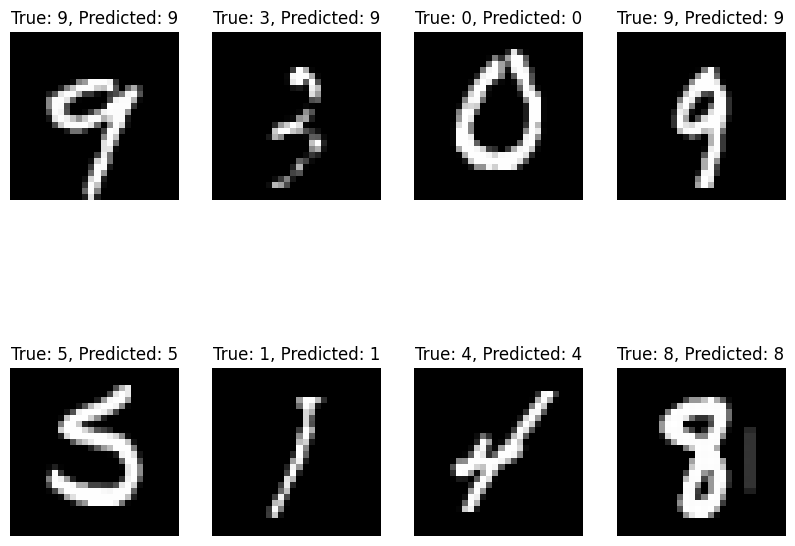

In [ ]:
# Test and classify
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

def image_classification(model, dataloader, n):          # n = number of images you want to classify
    model.eval()
    images, labels = next(iter(dataloader))

    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        out = model(images)
        _, preds = torch.max(out, 1)

    # Map predicted labels back to original classes
    predicted_classes = [label.item() for label in preds]

    # Display a subset of images with true and predicted labels
    plt.figure(figsize=(10, 8))
    for i in range(n):
        plt.subplot(2, 4, i + 1)
        plt.imshow(np.squeeze(images[i].cpu().numpy()), cmap='gray')
        plt.title(f"True: {labels[i].item()}, Predicted: {predicted_classes[i]}")
        plt.axis('off')

    plt.show()

image_classification(model1, test_loader1, n=8)

In [ ]:
# Model1 Test accuracy
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

accuracy1 = test_accuracy(model1, test_loader1)
print(f"Test accuracy for model1 = {accuracy1}")

Test accuracy for model1 = 97.88


##### Model2 training, validation and testing

In [ ]:
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

train_losses2, val_losses2, val_accuracies2 = train_validate_model(model2, optimizer2, train_loader1, test_loader1)

Epoch [1/10], Train Loss: 1.6583, Validation Loss: 0.0021, Validation Accuracy: 85.8900 
Epoch [2/10], Train Loss: 1.5331, Validation Loss: 0.0020, Validation Accuracy: 96.9200 
Epoch [3/10], Train Loss: 1.4956, Validation Loss: 0.0020, Validation Accuracy: 96.7300 
Epoch [4/10], Train Loss: 1.4922, Validation Loss: 0.0020, Validation Accuracy: 97.4700 
Epoch [5/10], Train Loss: 1.4898, Validation Loss: 0.0020, Validation Accuracy: 97.7300 
Epoch [6/10], Train Loss: 1.4882, Validation Loss: 0.0020, Validation Accuracy: 97.1400 
Epoch [7/10], Train Loss: 1.4878, Validation Loss: 0.0020, Validation Accuracy: 97.6100 
Epoch [8/10], Train Loss: 1.4870, Validation Loss: 0.0020, Validation Accuracy: 96.9600 
Epoch [9/10], Train Loss: 1.4877, Validation Loss: 0.0020, Validation Accuracy: 97.4800 
Epoch [10/10], Train Loss: 1.4860, Validation Loss: 0.0020, Validation Accuracy: 97.0400 


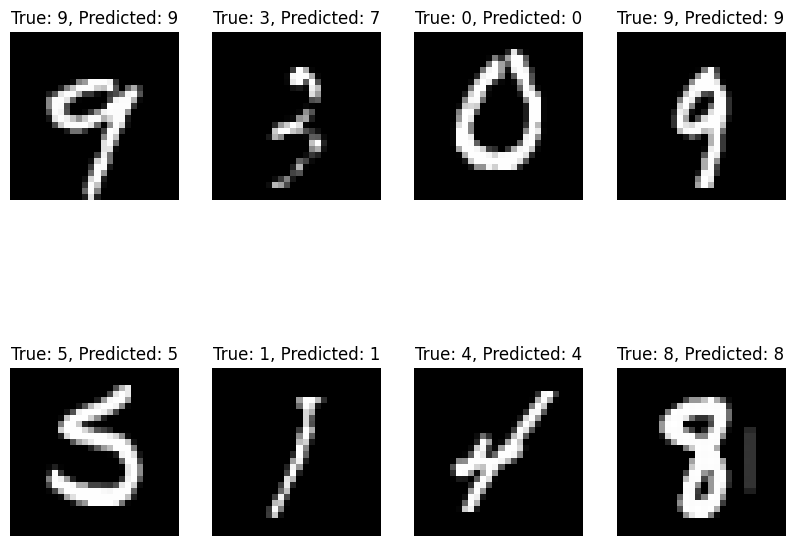

In [ ]:
# Test and classify

torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

def image_classification(model, dataloader, n):          # n = number of images you want to classify
    model.eval()
    images, labels = next(iter(dataloader))

    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        out = model(images)
        _, preds = torch.max(out, 1)

    # Map predicted labels back to original classes
    predicted_classes = [label.item() for label in preds]

    # Display a subset of images with true and predicted labels
    plt.figure(figsize=(10, 8))
    for i in range(n):
        plt.subplot(2, 4, i + 1)
        plt.imshow(np.squeeze(images[i].cpu().numpy()), cmap='gray')
        plt.title(f"True: {labels[i].item()}, Predicted: {predicted_classes[i]}")
        plt.axis('off')

    plt.show()

image_classification(model2, test_loader1, n=8)

In [ ]:
# Model2 Test accuracy
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

accuracy2 = test_accuracy(model2, test_loader1)
print(f"Test accuracy for model2 = {accuracy2}")

Test accuracy for model2 = 97.04


### Epochs vs Loss curve

For model1:

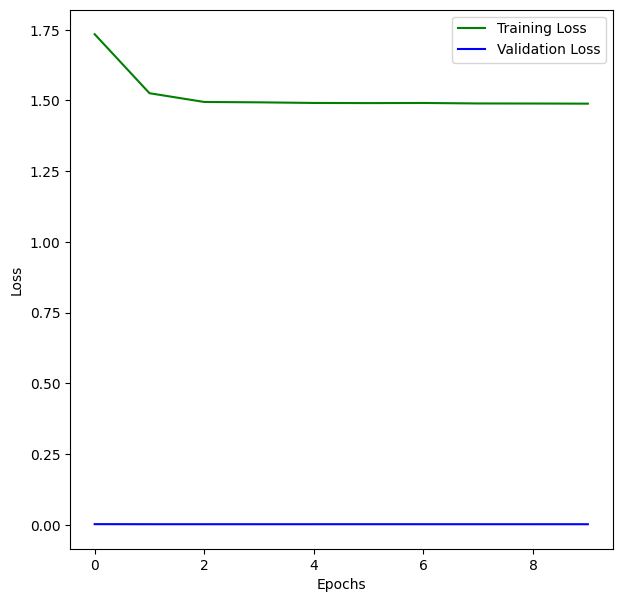

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(train_losses1, label='Training Loss', c='g')
plt.plot(val_losses1, label='Validation Loss', c='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

For model2:

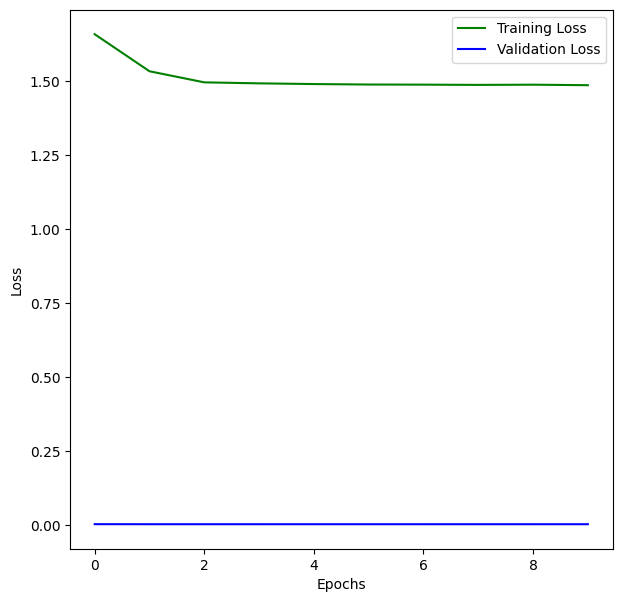

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(train_losses2, label='Training Loss', c='g')
plt.plot(val_losses2, label='Validation Loss', c='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Epochs vs Validation test Accuracy

For model1:

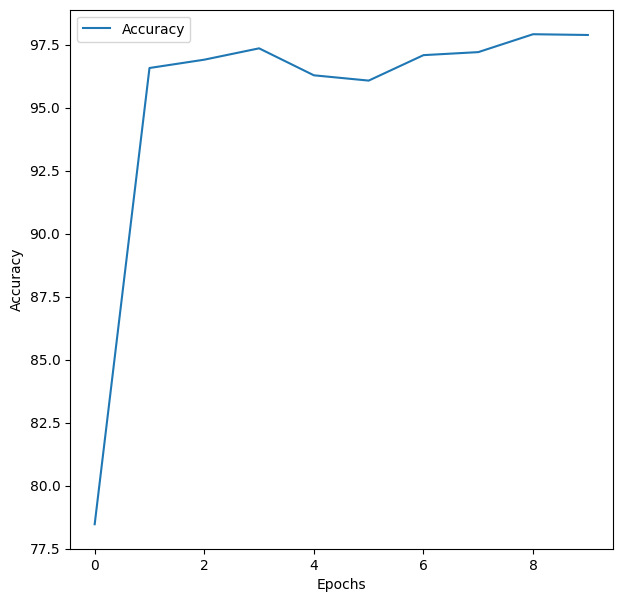

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(val_accuracies1, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

For model2:

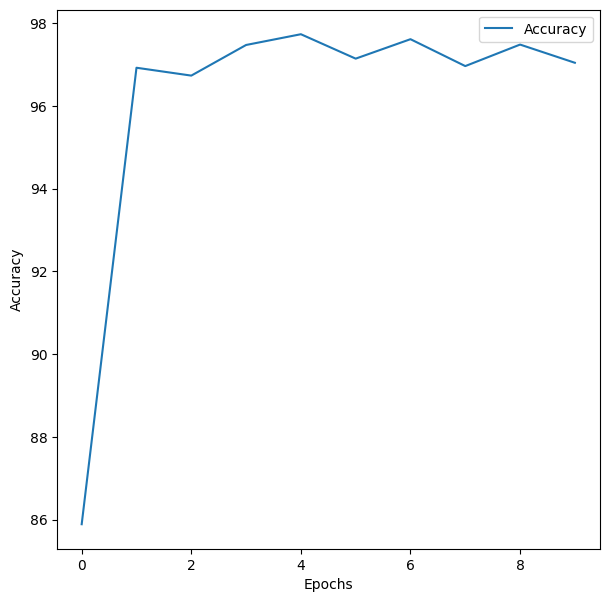

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(val_accuracies2, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Confusion matrix

For model1:

In [ ]:
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

model1.eval()
labels, preds = [], []

with torch.no_grad():
    for x, y in test_loader1:
        x, y = x.to(device), y.to(device)
        out = model1(x)
        _, predicted = torch.max(out.data, 1)
        labels.extend(y.data.cpu().numpy())
        preds.extend(predicted.data.cpu().numpy())

matrix1 = confusion_matrix(labels, preds)
print('Confusion Matrix for model1:')
print(matrix1)

Confusion Matrix for model1:
[[ 972    0    2    0    0    0    4    2    0    0]
 [   0 1123    4    0    1    2    0    5    0    0]
 [   6    0 1017    0    0    1    0    7    1    0]
 [   2    0   15  967    0    9    0    6    4    7]
 [   0    0    3    0  963    0    1    1    4   10]
 [   2    0    0    2    0  885    1    0    0    2]
 [   3    5    0    0    2    4  942    0    2    0]
 [   1    0    8    0    2    1    0 1011    1    4]
 [   8    0   17    1    0    6    3    4  924   11]
 [   4    2    2    0    3    8    0    5    1  984]]


For model2:

In [ ]:
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

model2.eval()
labels, preds = [], []

with torch.no_grad():
    for x, y in test_loader1:
        x, y = x.to(device), y.to(device)
        out = model2(x)
        _, predicted = torch.max(out.data, 1)
        labels.extend(y.data.cpu().numpy())
        preds.extend(predicted.data.cpu().numpy())

matrix2 = confusion_matrix(labels, preds)
print('Confusion Matrix for model2:')
print(matrix2)

Confusion Matrix for model2:
[[ 971    1    0    0    0    0    5    1    1    1]
 [   0 1123    0    6    0    0    3    2    1    0]
 [   1    5  918   54    6    0    0   46    2    0]
 [   0    0    0  993    0    4    0   11    2    0]
 [   0    2    1    0  973    0    0    3    0    3]
 [   2    0    0   14    0  871    3    1    0    1]
 [   8    3    1    1    3    6  932    0    4    0]
 [   0    1    1    1    0    0    0 1025    0    0]
 [   5    3    2    9    1    7    1   14  927    5]
 [   2    5    0    8    6    5    0   11    1  971]]


## Experiment 2
Creating new classes and classifying the images using the same CNNs used for model1 and model2.

New class groups are:

**Class 0: {0, 6}**

**Class 1: {1, 7}**

**Class 2: {2, 3, 8, 5}**

**Class 3: {4, 9}**

**The class numbers are started from 0 instead of 1 to avoid index bound error in later stage of code.**

### Create new classes and map with originals

In [ ]:
train_dataset = CustomDataset(X_train_file, y_train_file, transform=transform)

In [ ]:
new_classes = {0: 0, 6: 0, 1: 1, 7: 1, 2: 2, 3: 2, 8: 2, 5: 2, 4: 3, 9: 3}

# Map the original labels to the new classes
train_labels_mapped = torch.LongTensor([new_classes[label.item()] for label in train_dataset.labels])
test_labels_mapped = torch.LongTensor([new_classes[label.item()] for label in test_dataset.labels])

In [ ]:
print(train_labels_mapped)
print(test_labels_mapped)

tensor([2, 0, 3,  ..., 2, 0, 2])
tensor([1, 2, 1,  ..., 3, 2, 0])


### Convert to Tensors and DataLoaders

In [ ]:
# Convert to PyTorch tensors
train_images = torch.Tensor(train_dataset.images).unsqueeze(1)
test_images = torch.Tensor(test_dataset.images).unsqueeze(1)

# Create DataLoader
train_dataset2 = TensorDataset(train_images, train_labels_mapped)
test_dataset2 = TensorDataset(test_images, test_labels_mapped)

train_loader2 = DataLoader(train_dataset2, batch_size=batch_size, shuffle=True)
test_loader2 = DataLoader(test_dataset2, batch_size=batch_size, shuffle=True)

In [ ]:
# Length of the dataloaders
print("Length of train_loader2: {}, in batches of {}".format(len(train_loader2), batch_size))
print("Length of test_loader2: {}, in batches of {}".format(len(test_loader2), batch_size))

Length of train_loader2: 3750, in batches of 16
Length of test_loader2: 625, in batches of 16


### Display images of new classes

Show the images of the new batches formed using new class groups created.

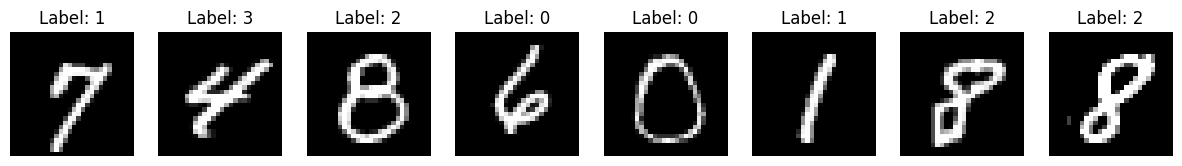

In [ ]:
def display(images, labels, ncols=8):
    nrows = np.ceil(len(images) / ncols)
    fig, axes = plt.subplots(int(nrows), ncols, figsize=(15, 2 * nrows))

    for i, (image, label) in enumerate(zip(images, labels)):
        ax = axes[i // ncols, i % ncols] if nrows > 1 else axes[i % ncols]
        ax.imshow(image.squeeze(), cmap='gray')
        ax.set_title(f"Label: {label}")
        ax.axis('off')

    plt.show()

for batch in train_loader2:
    batch_images, batch_labels = batch
    display(batch_images[:8], batch_labels[:8])
    break  #show one batch

The above images correctly fall in their respective class category

### Models and optimizers for new classes

In [ ]:
new_model1 = ConvNet(4, 3, 4*10*10).to(device)
new_model1

ConvNet(
  (cnn1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (avgpool3): AvgPool2d(kernel_size=3, stride=1, padding=0)
  (fc1): Linear(in_features=400, out_features=4, bias=True)
)

In [ ]:
new_model2 = ConvNet(4, 2, 4*12*12).to(device)
new_model2

ConvNet(
  (cnn1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (cnn3): Conv2d(8, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu3): ReLU()
  (avgpool3): AvgPool2d(kernel_size=2, stride=1, padding=0)
  (fc1): Linear(in_features=576, out_features=4, bias=True)
)

In [ ]:
optimizer_1 = torch.optim.Adam(params=new_model1.parameters(), lr=lr)
optimizer_2 = torch.optim.Adam(params=new_model2.parameters(), lr=lr)

### Training of new class images

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [ ]:
new_train_losses1, new_test_losses1, new_accuracies1 = train_validate_model(new_model1, optimizer_1, train_loader2, test_loader2)

Epoch [1/10], Train Loss: 1.3544, Validation Loss: 0.0018, Validation Accuracy: 39.0800 
Epoch [2/10], Train Loss: 1.3543, Validation Loss: 0.0018, Validation Accuracy: 39.0800 
Epoch [3/10], Train Loss: 1.3543, Validation Loss: 0.0018, Validation Accuracy: 39.0800 
Epoch [4/10], Train Loss: 1.3543, Validation Loss: 0.0018, Validation Accuracy: 39.0800 
Epoch [5/10], Train Loss: 1.3543, Validation Loss: 0.0018, Validation Accuracy: 39.0800 
Epoch [6/10], Train Loss: 1.3543, Validation Loss: 0.0018, Validation Accuracy: 39.0800 
Epoch [7/10], Train Loss: 1.3543, Validation Loss: 0.0018, Validation Accuracy: 39.0800 
Epoch [8/10], Train Loss: 1.3543, Validation Loss: 0.0018, Validation Accuracy: 39.0800 
Epoch [9/10], Train Loss: 1.3543, Validation Loss: 0.0018, Validation Accuracy: 39.0800 
Epoch [10/10], Train Loss: 1.3543, Validation Loss: 0.0018, Validation Accuracy: 39.0800 


In [ ]:
new_train_losses2, new_test_losses2, new_accuracies2 = train_validate_model(new_model2, optimizer_2, train_loader2, test_loader2)

Epoch [1/10], Train Loss: 0.8116, Validation Loss: 0.0010, Validation Accuracy: 96.2800 
Epoch [2/10], Train Loss: 0.8049, Validation Loss: 0.0011, Validation Accuracy: 95.5700 
Epoch [3/10], Train Loss: 0.8064, Validation Loss: 0.0011, Validation Accuracy: 94.7600 
Epoch [4/10], Train Loss: 0.8109, Validation Loss: 0.0011, Validation Accuracy: 93.6000 
Epoch [5/10], Train Loss: 0.8135, Validation Loss: 0.0011, Validation Accuracy: 93.8800 
Epoch [6/10], Train Loss: 0.8291, Validation Loss: 0.0010, Validation Accuracy: 96.1300 
Epoch [7/10], Train Loss: 0.8827, Validation Loss: 0.0011, Validation Accuracy: 93.4900 
Epoch [8/10], Train Loss: 0.8282, Validation Loss: 0.0011, Validation Accuracy: 95.5400 
Epoch [9/10], Train Loss: 0.8547, Validation Loss: 0.0013, Validation Accuracy: 74.9800 
Epoch [10/10], Train Loss: 0.8481, Validation Loss: 0.0011, Validation Accuracy: 95.4800 


### Epochs vs Loss curve

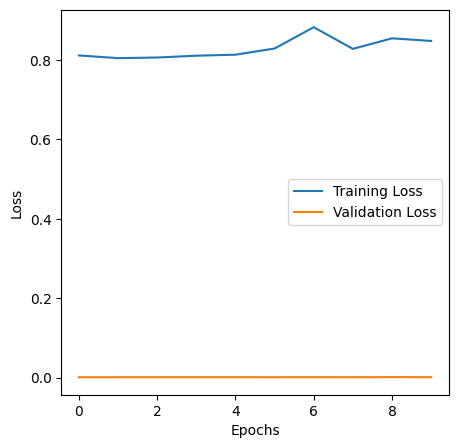

In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(new_train_losses2, label='Training Loss')
plt.plot(new_test_losses2, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Epoch vs Accuracy curve

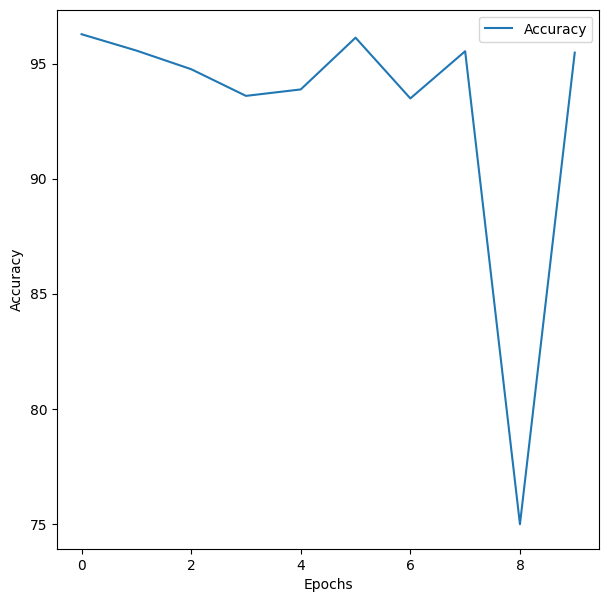

In [ ]:
plt.figure(figsize=(7, 7))
plt.plot(new_accuracies2, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Test accuracies of the new models

In [ ]:
# new_model1 Test accuracy
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

new_accuracy1 = test_accuracy(new_model1, test_loader2)
print(f"Test accuracy for new_model2 = {new_accuracy1} %")

Test accuracy for new_model2 = 39.08 %


In [ ]:
# new_model2 Test accuracy
torch.manual_seed(42)
if torch.cuda.is_available():
   torch.cuda.manual_seed(42)

new_accuracy2 = test_accuracy(new_model2, test_loader2)
print(f"Test accuracy for new_model2 = {new_accuracy2} %")

Test accuracy for new_model2 = 95.48 %


### Classification of the test images

In [ ]:
def image_classification(model, dataloader, n):          # n = number of images you want to classify
    model.eval()
    images, labels = next(iter(dataloader))

    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)
        out = model(images)
        _, preds = torch.max(out, 1)

    # Map predicted labels back to original classes
    predicted_classes = [label.item() for label in preds]

    # Display a subset of images with true and predicted labels
    plt.figure(figsize=(10, 8))
    for i in range(n):
        plt.subplot(2, 4, i + 1)
        plt.imshow(np.squeeze(images[i].cpu().numpy()), cmap='gray')
        plt.title(f"True: {labels[i].item()}, Predicted: {predicted_classes[i]}")
        plt.axis('off')

    plt.show()

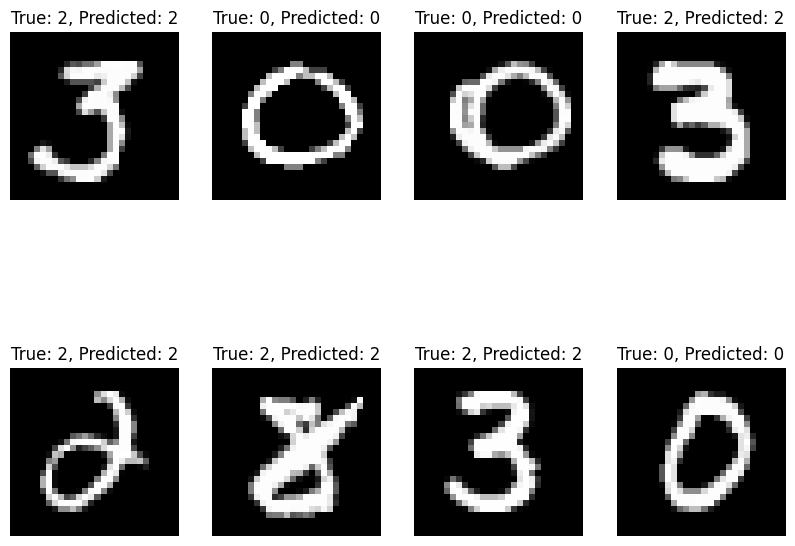

In [ ]:
# Classification using new_model2
image_classification(new_model2, test_loader2, n=8)

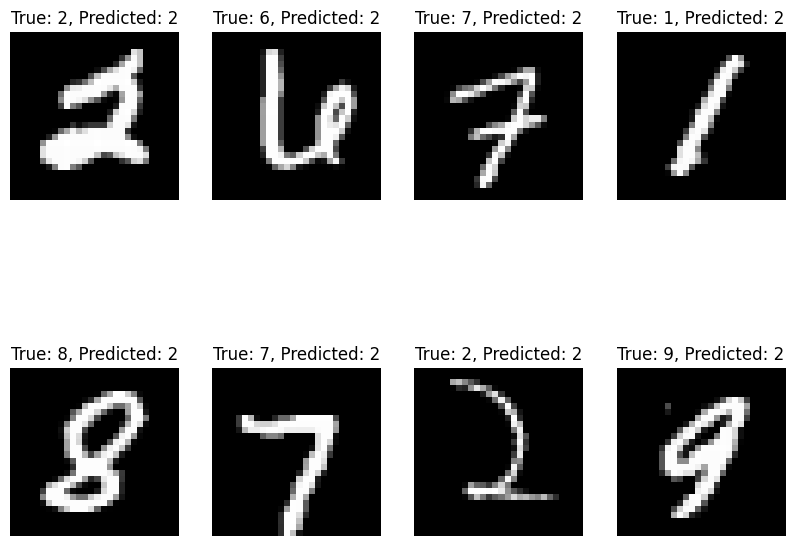

In [ ]:
# Classification using new_model1
image_classification(new_model1, test_loader1, n=8)